# U-Net for Semantic Segmentation and Crowd Counting


In [6]:
!pip install torchvision opencv-python matplotlib --quiet

import os
import cv2
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from scipy.ndimage import gaussian_filter

import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import OxfordIIITPet

# ==============================
# PART 1: SEGMENTATION TASK
# ==============================

In [7]:
class OxfordPetDataset(Dataset):
    def __init__(self, root, split='train', transform=None, target_transform=None):
        self.dataset = OxfordIIITPet(root=root, split=split, target_types="segmentation", download=True)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, mask = self.dataset[idx]
        mask = np.array(mask)
        mask = (mask > 1).astype(np.uint8)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)

        return image, mask

transform = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor()
])

target_transform = T.Compose([
    lambda x: Image.fromarray(x),
    T.Resize((128, 128)),
    T.ToTensor()
])

train_seg_dataset = OxfordPetDataset('./data', split='trainval', transform=transform, target_transform=target_transform)
train_seg_loader = DataLoader(train_seg_dataset, batch_size=16, shuffle=True)


# ==============================
# PART 2: CROWD COUNTING TASK
# ==============================

In [8]:
class SyntheticCrowdDataset(Dataset):
    def __init__(self, num_samples=100, image_size=(128, 128), max_people=30):
        self.num_samples = num_samples
        self.image_size = image_size
        self.max_people = max_people

    def generate_image_and_density(self):
        image = np.zeros(self.image_size, dtype=np.float32)
        density_map = np.zeros(self.image_size, dtype=np.float32)
        num_people = random.randint(1, self.max_people)

        for _ in range(num_people):
            x = random.randint(0, self.image_size[0] - 1)
            y = random.randint(0, self.image_size[1] - 1)
            image[x, y] = 1.0
            density_map[x, y] = 1.0

        density_map = gaussian_filter(density_map, sigma=3)
        return image, density_map

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        image, density = self.generate_image_and_density()
        image = np.expand_dims(image, axis=0)
        density = np.expand_dims(density, axis=0)
        return torch.tensor(image, dtype=torch.float32), torch.tensor(density, dtype=torch.float32)

train_crowd_dataset = SyntheticCrowdDataset(num_samples=200)
train_crowd_loader = DataLoader(train_crowd_dataset, batch_size=8, shuffle=True)

# ==============================
# U-Net Model Definition
# ==============================

In [9]:
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(128, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv1 = DoubleConv(128, 64)

        self.output = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        d1 = self.down1(x)
        p1 = self.pool1(d1)
        d2 = self.down2(p1)
        p2 = self.pool2(d2)

        b = self.bottleneck(p2)

        u2 = self.up2(b)
        u2 = torch.cat([u2, d2], dim=1)
        c2 = self.conv2(u2)

        u1 = self.up1(c2)
        u1 = torch.cat([u1, d1], dim=1)
        c1 = self.conv1(u1)

        return torch.sigmoid(self.output(c1))


# ==============================
# Training Segmentation Model
# ==============================

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_seg = UNet(in_channels=3, out_channels=1).to(device)
optimizer = torch.optim.Adam(model_seg.parameters(), lr=1e-3)
criterion = nn.BCELoss()

for epoch in range(5):
    model_seg.train()
    total_loss = 0
    for images, masks in tqdm(train_seg_loader):
        images, masks = images.to(device), masks.to(device)
        outputs = model_seg(images)
        loss = criterion(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[Segmentation] Epoch {epoch+1}, Loss: {total_loss:.4f}")


100%|██████████| 230/230 [00:43<00:00,  5.25it/s]


[Segmentation] Epoch 1, Loss: 64.0224


100%|██████████| 230/230 [00:41<00:00,  5.56it/s]


[Segmentation] Epoch 2, Loss: 63.1758


100%|██████████| 230/230 [00:43<00:00,  5.31it/s]


[Segmentation] Epoch 3, Loss: 63.1758


100%|██████████| 230/230 [00:41<00:00,  5.49it/s]


[Segmentation] Epoch 4, Loss: 63.1758


100%|██████████| 230/230 [00:42<00:00,  5.44it/s]

[Segmentation] Epoch 5, Loss: 63.1758


# ==============================
# Training Crowd Counting Model
# ==============================

In [11]:
model_count = UNet(in_channels=1, out_channels=1).to(device)
optimizer = torch.optim.Adam(model_count.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for epoch in range(10):
    model_count.train()
    total_loss = 0
    for images, densities in train_crowd_loader:
        images, densities = images.to(device), densities.to(device)
        outputs = model_count(images)
        loss = criterion(outputs, densities)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[Counting] Epoch {epoch+1}, Loss: {total_loss:.4f}")


[Counting] Epoch 1, Loss: 0.9414
[Counting] Epoch 2, Loss: 0.0003
[Counting] Epoch 3, Loss: 0.0003
[Counting] Epoch 4, Loss: 0.0002
[Counting] Epoch 5, Loss: 0.0002
[Counting] Epoch 6, Loss: 0.0002
[Counting] Epoch 7, Loss: 0.0002
[Counting] Epoch 8, Loss: 0.0003
[Counting] Epoch 9, Loss: 0.0003
[Counting] Epoch 10, Loss: 0.0003


# ==============================
# Evaluation & Visualization
# ==============================

GT Count: 14.00, Predicted Count: 0.00


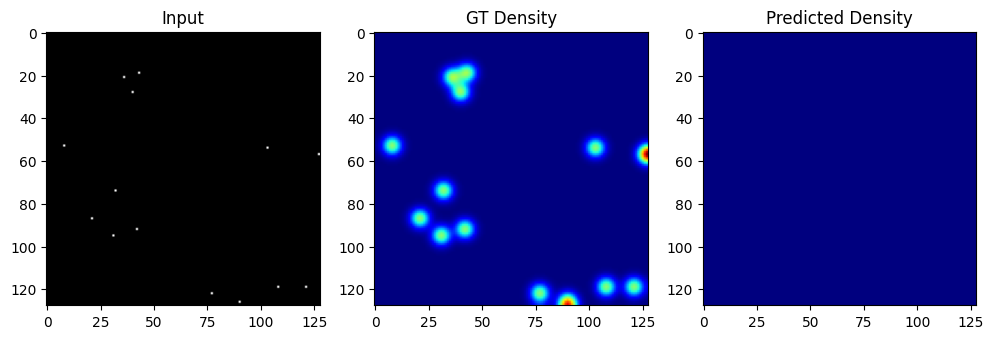

In [12]:
model_count.eval()
with torch.no_grad():
    img, gt_density = train_crowd_dataset[0]
    img = img.unsqueeze(0).to(device)
    pred = model_count(img).squeeze().cpu().numpy()
    gt = gt_density.squeeze().numpy()

    print(f"GT Count: {gt.sum():.2f}, Predicted Count: {pred.sum():.2f}")

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img.squeeze().cpu(), cmap='gray')
    plt.title("Input")
    plt.subplot(1, 3, 2)
    plt.imshow(gt, cmap='jet')
    plt.title("GT Density")
    plt.subplot(1, 3, 3)
    plt.imshow(pred, cmap='jet')
    plt.title("Predicted Density")
    plt.show()
